### Load required libraries and data

In [1]:
import os
import anndata as ad
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import copy
import re
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from datetime import datetime
from igraph import *
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import arviz as az

pwd = os.getcwd()

def run_scCODA(cell_count, random_effect, split_key, split_value, labels_keys, tests, region, covariates, formula, diagnostic_plots=True, figsize=(20,6)):
    for j in labels_keys:
        print(str(datetime.now()) + " -- Starting labels_keys=" + j)
        cell_count = cell_count.loc[[i in split_value for i in cell_count[split_key]], :]
        counts = sp.sparse.csr_matrix(np.random.poisson(1, size=(cell_count.shape[0], 0)), dtype=np.float32)
        adata = ad.AnnData(counts)
        adata.obs_names = cell_count.index
        adata.obs = cell_count

        abundances = dat.from_scanpy(
            adata,
            cell_type_identifier=j,
            sample_identifier=random_effect,
        )
        tmp = adata.obs.loc[:, covariates]
        tmp.drop_duplicates(inplace=True)
        tmp.index = tmp.library_prep
        tmp.drop([random_effect], axis=1, inplace=True)
        abundances.obs = tmp.loc[abundances.obs.index, :]

        if diagnostic_plots == True:
            tmp = abundances.obs.copy()
            for i in tmp.columns:
                if i.endswith("_codes"):
                    continue
                tmp[i] = tmp[i].astype("category")
                tmp[i + "_codes"] = tmp[i].cat.codes
                tmp.drop(i, axis=1, inplace=True)
            results = np.zeros((tmp.shape[1],tmp.shape[1]))

            for a in range(tmp.shape[1]):
                for b in range(tmp.shape[1]):
                    results[a,b] = sp.stats.spearmanr(tmp.iloc[:,a], tmp.iloc[:,b])[0]

            results = pd.DataFrame(results, columns=tmp.columns, index=tmp.columns)
            sns.heatmap(results);
            plt.show()
            try:
                boxplots(abundances, feature_name="region", figsize=figsize, y_scale="log_relative")
            except:
                boxplots(abundances, feature_name="species", figsize=figsize, y_scale="log_relative")
            boxplots(abundances, feature_name="sex", figsize=figsize, y_scale="log_relative")
            plt.show()

        outfile = " ".join(split_value) + "_" + j + "_results.csv"
              
        for k in tests:
            print(str(datetime.now()) + " -- testing across " + k)
            if (abundances.obs[k].dtype == "object" and len(np.unique(abundances.obs[k])) < 3) or abundances.obs[k].dtype != "object":
                if os.path.exists(os.path.join(pwd, "output", region, k)) is False:
                    os.makedirs(os.path.join(pwd, "output", region, k))
                i = 0
                cell_types = abundances.var.index
                try:
                    del results_table
                except:
                    pass

                while i < cell_types.shape[0]:    

                    ct = cell_types[i]
                    print("Reference: " + ct)

                    pickle_file = os.path.join(pwd, "output", region, k, ct.replace("/", " ") + ".pkl")
                    if os.path.exists(pickle_file):
                        with open(pickle_file, 'rb') as pickle_load:
                            results = pickle.load(pickle_load)

                    else:
                        models = mod.CompositionalAnalysis(abundances, formula=formula + k, reference_cell_type=ct)
                        results = models.sample_hmc()
                        results.save(pickle_file)

                    accepted = results.sample_stats["is_accepted"].to_numpy()

                    if accepted.sum() / accepted.shape[1] < 0.6:
                        del results
                        os.remove(pickle_file)
                        print("Did not achieve acceptance threshold, trying again")
                        continue

                    else:
                        print("Converged!")
                        i = i + 1

                    current_results = results.summary_prepare()[1]
                    current_results = current_results.reset_index()
                    current_results["Reference Cell Type"] = ct

                    try:
                        results_table = pd.concat([results_table, current_results], axis=0)
                    except:
                        results_table = current_results.copy()

                results_table.to_csv(os.path.join(pwd, "output", region, k, outfile))
            else:
                for l in np.unique(abundances.obs[k]):
                    if os.path.exists(os.path.join(pwd, "output", region, k, l)) is False:
                        os.makedirs(os.path.join(pwd, "output", region, k, l))

                    print("Reference " + k + ": " + l)
                    i = 0
                    cell_types = abundances.var.index
                    try:
                        del results_table
                    except:
                        pass

                    while i < cell_types.shape[0]:    

                        ct = cell_types[i]
                        print("Reference cell type: " + ct)

                        pickle_file = os.path.join(pwd, "output", region, k, l, ct.replace("/", " ") + ".pkl")
                        if os.path.exists(pickle_file):
                            with open(pickle_file, 'rb') as pickle_load:
                                results = pickle.load(pickle_load)

                        else:
                            models = mod.CompositionalAnalysis(abundances, formula=formula + "C(" + k + ", Treatment('" + l + "'))", reference_cell_type=ct)
                            results = models.sample_hmc()
                            results.save(pickle_file)

                        accepted = results.sample_stats["is_accepted"].to_numpy()

                        if accepted.sum() / accepted.shape[1] < 0.6:
                            del results
                            os.remove(pickle_file)
                            print("Did not achieve acceptance threshold, trying again")
                            continue

                        else:
                            print("Converged!")
                            i = i + 1

                        current_results = results.summary_prepare()[1]
                        current_results = current_results.reset_index()
                        current_results["Reference Cell Type"] = ct

                        try:
                            results_table = pd.concat([results_table, current_results], axis=0)
                        except:
                            results_table = current_results.copy()

                    results_table.to_csv(os.path.join(pwd, "output", region, k, l, outfile)) 
            
def boxplots(
        data,
        feature_name,
        y_scale="relative",
        plot_facets=False,
        add_dots=False,
        cell_types=None,
        args_boxplot={},
        args_swarmplot={},
        figsize=None,
        dpi=100,
        cmap="Blues",
        plot_legend=True,
        level_order=None):
    """
    Grouped boxplot visualization. The cell counts for each cell type are shown as a group of boxplots,
    with intra--group separation by a covariate from data.obs.
    The cell type groups can either be ordered along the x-axis of a single plot (plot_facets=False) or as plot facets (plot_facets=True).
    Parameters
    ----------
    data
        A scCODA-compatible data object
    feature_name
        The name of the feature in data.obs to plot
    y_scale
        Transformation to of cell counts. Options: "relative" - Relative abundance, "log" - log(count), "count" - absolute abundance (cell counts)
    plot_facets
        If False, plot cell types on the x-axis. If True, plot as facets
    add_dots
        If True, overlay a scatterplot with one dot for each data point
    cell_types
        Subset of cell types that should be plotted
    args_boxplot
        Arguments passed to sns.boxplot
    args_swarmplot
            Arguments passed to sns.swarmplot
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The seaborn color map for the barplot
    plot_legend
        If True, adds a legend
    level_order
        Custom ordering of bars on the x-axis
    Returns
    -------
    Depending on `plot_facets`, returns a :class:`~plt.AxesSubplot` (`plot_facets = False`) or :class:`~sns.axisgrid.FacetGrid` (`plot_facets = True`) object
    ax
        if `plot_facets = False`
    g
        if `plot_facets = True`
    """

    # y scale transformations
    if y_scale == "relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = data.X/sample_sums
        value_name = "Proportion"
    elif y_scale == "log_relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = np.log10((data.X + 1)/(sample_sums + data.shape[1]))
        value_name = "log(Proportion)"
    # add pseudocount 1 if using log scale (needs to be improved)
    elif y_scale == "log":
        X = np.log10(data.X + 1)
        value_name = "log(count)"
    elif y_scale == "count":
        X = data.X
        value_name = "count"
    else:
        raise ValueError("Invalid y_scale transformation")

    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    if cell_types is not None:
        plot_df = plot_df[plot_df["Cell type"].isin(cell_types)]

    if plot_facets:

        if level_order is None:
            level_order = pd.unique(plot_df[feature_name])

        K = X.shape[1]

        g = sns.FacetGrid(
            plot_df,
            col="Cell type",
            sharey=False,
            col_wrap=np.floor(np.sqrt(K)),
            height=5,
            aspect=2,
        )
        g.map(
            sns.boxplot,
            feature_name,
            value_name,
            palette=cmap,
            order=level_order,
            **args_boxplot
        )

        if add_dots:

            if "hue" in args_swarmplot:
                hue = args_swarmplot.pop("hue")
            else:
                hue = None

            if hue is None:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    color="black",
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
            else:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    hue,
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")

        return g

    else:

        if level_order:
            args_boxplot["hue_order"] = level_order
            args_swarmplot["hue_order"] = level_order

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.boxplot(x="Cell type", y=value_name, hue=feature_name, data=plot_df, fliersize=1,
                    palette=cmap, ax=ax, **args_boxplot)

        if add_dots:
            sns.swarmplot(
                x="Cell type",
                y=value_name,
                data=plot_df,
                hue=feature_name,
                ax=ax,
                dodge=True,
                color="black",
                **args_swarmplot
            )

        cell_types = pd.unique(plot_df["Cell type"])
        ax.set_xticklabels(cell_types, rotation=90)

        if plot_legend:
            handles, labels = ax.get_legend_handles_labels()
            handout = []
            labelout = []
            for h, l in zip(handles, labels):
                if l not in labelout:
                    labelout.append(l)
                    handout.append(h)
            ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

        plt.tight_layout()

        return ax

2024-08-03 12:16:34.318291: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 12:16:34.324826: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 12:16:34.338098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 12:16:34.358214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 12:16:34.364301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 12:16:34.381367: I tensorflow/core/platform/cpu_feature_gu

#### Run scCODA on non-neuronal cells

In [10]:
cell_count = pd.read_csv("./8_wholeMeta.csv")
#cell_count["library_prep"] = [re.sub("[ATGC]+-[0-9]{0,3}([^-]+)(-[0-9]+)?$", "\\1", i) for i in cell_count.index]
#cell_count = cell_count.loc[cell_count["dataset"] != "lein_10x_layer5_only", :].copy()

/tmp/ipykernel_1106723/3737267532.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_count = pd.read_csv("./8_wholeMeta.csv")


2024-08-03 01:02:58.313722 -- Starting labels_keys=cross_area_subclass


/home/luomeng/miniconda3/envs/sccoda/lib/python3.9/site-packages/anndata/_core/anndata.py:841: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/luomeng/miniconda3/envs/sccoda/lib/python3.9/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


No covariate information specified!


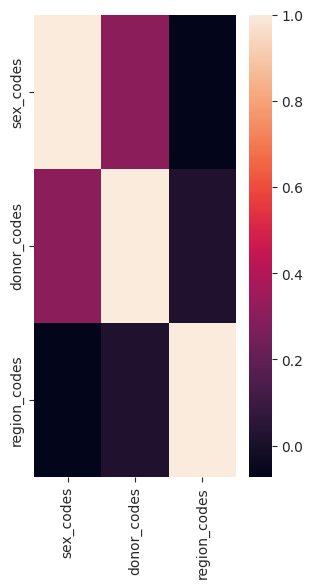

/tmp/ipykernel_1106723/556620346.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)
/tmp/ipykernel_1106723/556620346.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


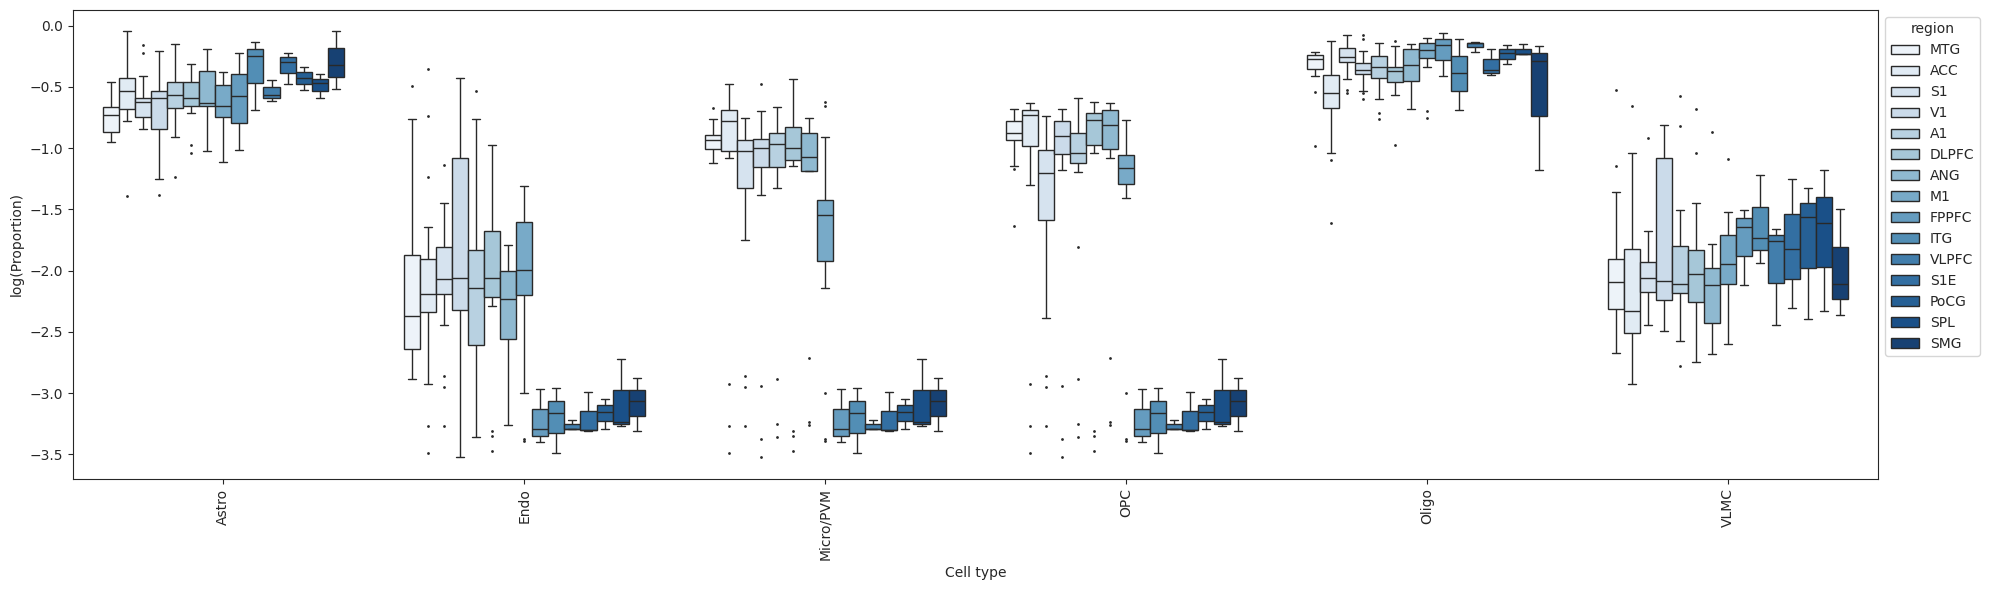

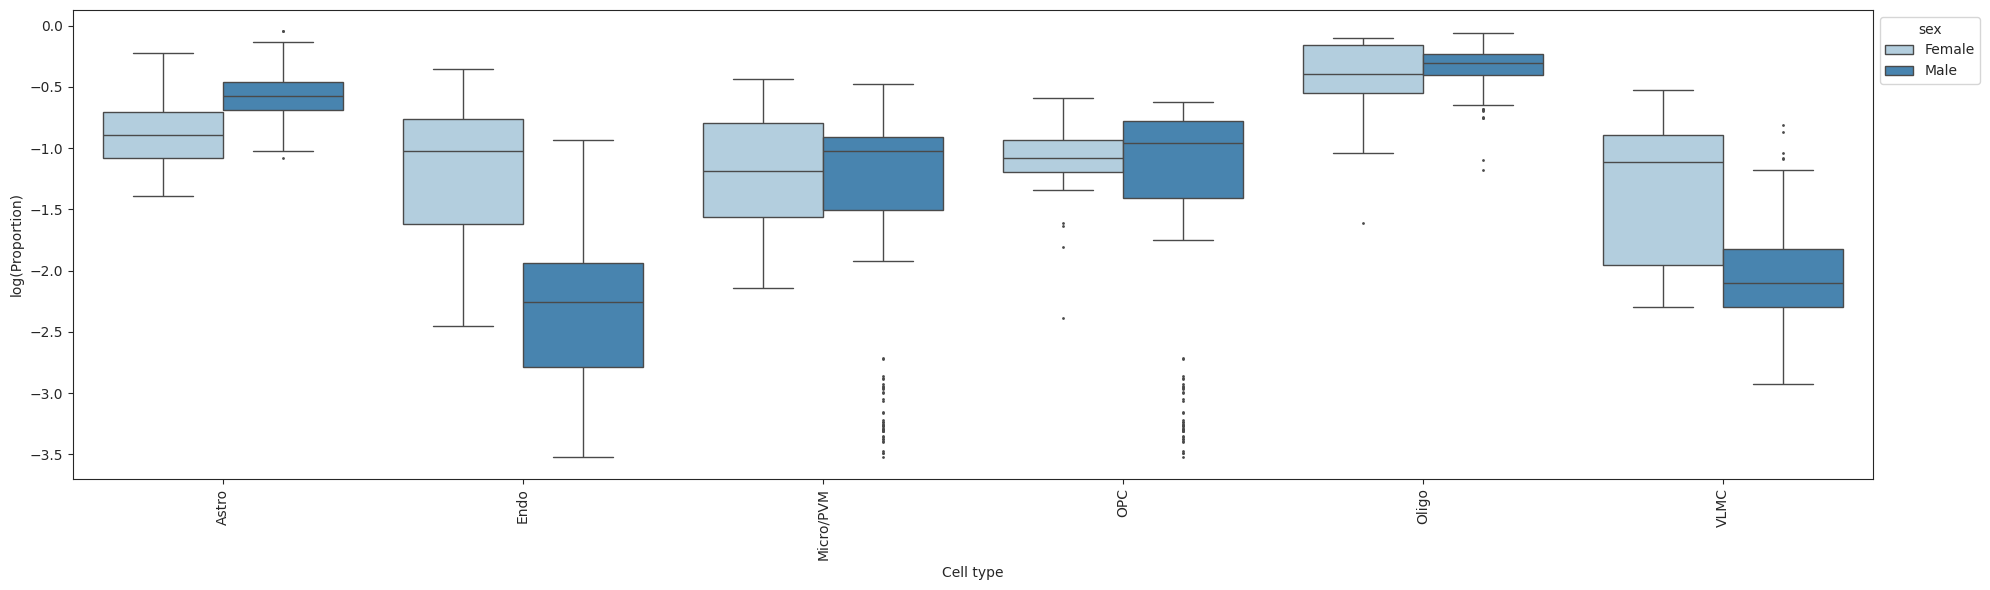

2024-08-03 01:02:59.970287 -- testing across region
Reference region: A1
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: ACC
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC


/home/luomeng/miniconda3/envs/sccoda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Converged!
Reference region: ANG
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: DLPFC
Reference cell type: Astro


2024-08-03 01:03:05.406939: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Zero counts encountered in data! Added a pseudocount of 0.5.


  0%|                                                 | 0/20000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1722618187.517782 1108561 service.cc:146] XLA service 0x7fbd34296250 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722618187.517870 1108561 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-08-03 01:03:07.585912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722618188.283423 1108561 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|█████████████████████████████████████| 20000/20000 [04:03<00:00, 82.08it/s]


MCMC sampling finished. (305.123 sec)
Acceptance rate: 69.9%


/home/luomeng/miniconda3/envs/sccoda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Converged!


/home/luomeng/miniconda3/envs/sccoda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


 68%|█████████████████████████▎           | 13649/20000 [02:55<01:19, 80.33it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



MCMC sampling finished. (316.402 sec)
Acceptance rate: 48.4%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:06<00:00, 81.28it/s]


MCMC sampling finished. (309.303 sec)
Acceptance rate: 49.8%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:19<00:00, 77.22it/s]


MCMC sampling finished. (323.876 sec)
Acceptance rate: 53.7%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:08<00:00, 80.57it/s]


MCMC sampling finished. (311.044 sec)
Acceptance rate: 41.8%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:16<00:00, 77.87it/s]


MCMC sampling finished. (322.066 sec)
Acceptance rate: 38.0%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:20<00:00, 76.81it/s]


MCMC sampling finished. (326.645 sec)
Acceptance rate: 32.6%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:23<00:00, 75.83it/s]


MCMC sampling finished. (329.444 sec)
Acceptance rate: 57.6%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


 57%|█████████████████████                | 11380/20000 [02:36<01:57, 73.34it/s]

MCMC sampling finished. (348.522 sec)
Acceptance rate: 40.7%
Did not achieve acceptance threshold, trying again
Reference cell type: Endo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:36<00:00, 72.44it/s]


MCMC sampling finished. (346.960 sec)
Acceptance rate: 64.5%
Converged!
Reference cell type: Micro/PVM
Zero counts encountered in data! Added a pseudocount of 0.5.


 20%|███████▍                              | 3940/20000 [00:52<03:26, 77.93it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Did not achieve acceptance threshold, trying again
Reference cell type: Micro/PVM
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:09<00:00, 80.18it/s]


MCMC sampling finished. (314.119 sec)
Acceptance rate: 48.0%
Did not achieve acceptance threshold, trying again
Reference cell type: Micro/PVM
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:16<00:00, 78.04it/s]


MCMC sampling finished. (319.279 sec)
Acceptance rate: 71.9%
Converged!
Reference cell type: OPC
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:11<00:00, 79.41it/s]


MCMC sampling finished. (313.973 sec)
Acceptance rate: 45.8%
Did not achieve acceptance threshold, trying again
Reference cell type: OPC
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:03<00:00, 81.97it/s]


MCMC sampling finished. (305.608 sec)
Acceptance rate: 72.4%
Converged!
Reference cell type: Oligo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:01<00:00, 82.74it/s]


MCMC sampling finished. (303.125 sec)
Acceptance rate: 24.6%
Did not achieve acceptance threshold, trying again
Reference cell type: Oligo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:04<00:00, 81.96it/s]


MCMC sampling finished. (306.480 sec)
Acceptance rate: 48.3%
Did not achieve acceptance threshold, trying again
Reference cell type: Oligo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:09<00:00, 80.06it/s]


MCMC sampling finished. (311.986 sec)
Acceptance rate: 42.0%
Did not achieve acceptance threshold, trying again
Reference cell type: Oligo
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:01<00:00, 82.79it/s]


MCMC sampling finished. (305.036 sec)
Acceptance rate: 69.1%
Converged!
Reference cell type: VLMC
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:01<00:00, 82.90it/s]


MCMC sampling finished. (303.941 sec)
Acceptance rate: 49.5%
Did not achieve acceptance threshold, trying again
Reference cell type: VLMC
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████| 20000/20000 [04:09<00:00, 80.09it/s]


MCMC sampling finished. (312.378 sec)
Acceptance rate: 41.0%
Did not achieve acceptance threshold, trying again
Reference cell type: VLMC
Zero counts encountered in data! Added a pseudocount of 0.5.


 63%|███████████████████████▍             | 12676/20000 [02:36<01:26, 84.39it/s]

In [ ]:
region = "cross_areal"
formula = "sex + "
covariates = ["library_prep", "sex", "donor", "region"]
tests = ["region"]
labels_keys=["cross_area_subclass", "cross_area_cluster"]
run_scCODA(
    cell_count=cell_count,
    random_effect="library_prep",
    split_key="class",
    split_value=["non-neuronal"],
    labels_keys=labels_keys,
    region=region,
    covariates=covariates,
    tests=tests,
    formula=formula,
    figsize=(20,6)
)

In [9]:
plt.rcParams['figure.figsize'] = (3.26,6)
print("1")
dend_order = pd.read_csv("dend_order_glia.csv", header=None)

1


In [11]:
tests

NameError: name 'tests' is not defined

In [12]:
print("2")
plot_size = {"class": [-1, 1], "cross_area_subclass": [-1.75, 1.75], "cross_area_cluster": [-6, 6]}
plot_order = {"cross_area_cluster": dend_order.iloc[:, 0].to_list()}
print("3")

2
3


In [17]:
plot_colors = {}
covariate_order = ["FPPFC", "V1", "ITG", "DLPFC", "VLPFC", "M1", "S1", "S1E", 
"PoCG", "ANG", "ACC", "SPL", "SMG", "A1", "MTG", "sex[T.Male]"]
drop_covariates = ["sex[T.Male]"]

region
cross_area_subclass
output/cross_areal/region/DLPFC/non-neuronal_cross_area_subclass_results.csv
output/cross_areal/region/M1/non-neuronal_cross_area_subclass_results.csv
output/cross_areal/region/MTG/non-neuronal_cross_area_subclass_results.csv
output/cross_areal/region/ANG/non-neuronal_cross_area_subclass_results.csv
output/cross_areal/region/FPPFC/non-neuronal_cross_area_subclass_results.csv
output/cross_areal/region/ACC/non-neuronal_cross_area_subclass_results.csv
output/cross_areal/region/A1/non-neuronal_cross_area_subclass_results.csv
output/cross_areal/region/ITG/non-neuronal_cross_area_subclass_results.csv


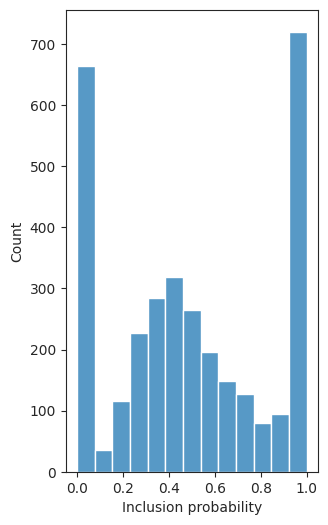

/tmp/ipykernel_1420335/4079723822.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = results_table.loc[:, ["Covariate", "Cell Type", "Final Parameter"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
Traceback (most recent call last):
  File "/home/luomeng/miniconda3/envs/sccoda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1420335/4079723822.py", line 48, in <module>
    );        plt.savefig(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_unfiltered.pdf"), bbox_inches="tight")
  File "/home/luomeng/miniconda3/envs/sccoda/lib/python3.9/site-packages/matplotlib/pyplot.py", line 1228, in savefig
    res = fig.savefig(*args, **kwargs)  # 

Unexpected exception formatting exception. Falling back to standard exception


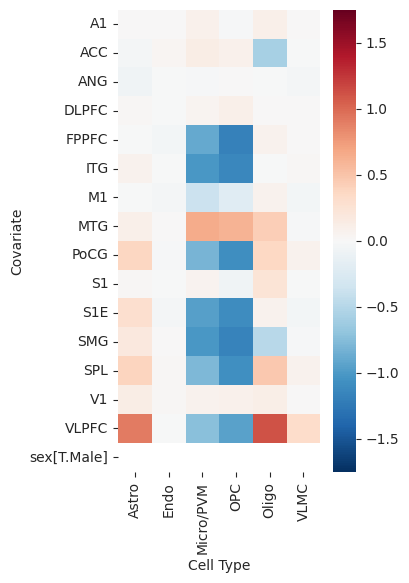

In [19]:
for j in tests:
    print(j)
    for k in labels_keys:
        print(k)
        results_tables = glob.glob(os.path.join("output", region, j, "**", "non-neuronal_" + k + "_results.csv"))
        results_table = False
        for z in results_tables:
            print(z)
            tmp = pd.read_csv(z, index_col=0)
            tmp["Covariate"] = [re.sub("C\([^,]+, Treatment\('[^\)]+'\)\)\[T.([^\]]+)\]$", "\\1", y) for y in tmp["Covariate"]]
            try:
                results_table = pd.concat([results_table, tmp], axis=0)
            except:
                results_table = tmp.copy()
        
        results_table["Credible"] = results_table["Final Parameter"] != 0
        
        try:
            results_table["Cell Type"] = results_table["Cell Type"].astype("category")
            results_table["Cell Type"].cat.reorder_categories(plot_order[k], inplace=True) 
        except:
            pass
        
        try:
            results_table["Covariate"] = results_table["Covariate"].astype("category")
            results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
        except:
            pass
        
        try:
            results_table = results_table.loc[[l not in drop_covariates for l in results_table["Covariate"]], :]
            results_table["Covariate"].cat.remove_unused_categories(inplace=True)
        except:
            pass
        
        sns.histplot(results_table["Inclusion probability"]);
        plt.show();
        
        tmp = results_table.loc[:, ["Covariate", "Cell Type", "Final Parameter"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
        tmp.columns = ["Covariate", "Cell Type", "Effect Size"]
        ax = sns.heatmap(
            tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
            center=0,
            cmap="RdBu_r",
            vmin=plot_size[k][0],
            vmax=plot_size[k][1],
            xticklabels=True
        );        plt.savefig(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_unfiltered.pdf"), bbox_inches="tight")
        plt.show();
        tmp.to_csv(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_unfiltered.csv"))
        
        tmp2 = results_table.loc[:, ["Covariate", "Cell Type", "Inclusion probability"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
        tmp.loc[tmp2["Inclusion probability"] < 0.8, "Effect Size"] = 0
        ax = sns.heatmap(
            tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
            center=0, cmap="RdBu_r",
            vmin=plot_size[k][0],
            vmax=plot_size[k][1],
            xticklabels=True
        );        plt.savefig(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_p_gt_0.8.pdf"), bbox_inches="tight")
        plt.show();
        tmp.to_csv(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_p_gt_0.8.csv"))
            
plt.rcParams['figure.figsize'] = (6,4)